---
title: "Attri-VAE for Interpretable Prediction of Myocardial Infarction Complications"
authors:
  - name: "Mithun Manivannan"
  - course: DATASCI 3ML3 Final Project
    affiliation: "Department of Physics and Astronomy, McMaster University"
    email: "manivanm@mcmaster.ca"
    orcid: "0009-0006-2277-2687"  

date: "April 23, 2025"
---

In [ ]:
#!pip install torch numpy pandas matplotlib seaborn scikit-learn tensorboard


## Dataset
We use the Myocardial Infarction Complications dataset from the UCI Machine Learning Repository. The dataset includes 4,876 patients with 138 features, covering demographics, laboratory measurements, vital signs, medical history, medication use, and in-hospital complications.

## Notebook Structure
1. **Data Loading and Preprocessing**
   - Feature standardization
   - Handling missing values
   - Feature grouping for sparsity regularization

2. **Model Implementation**
   - VAE architecture with encoder and decoder networks
   - Group sparsity regularization mechanism
   - Missing data handling approach

3. **Training and Evaluation**
   - Training loop with annealing schedules
   - TensorBoard integration
   - Model evaluation metrics

4. **Results and Visualization**
   - t-SNE visualization of latent space
   - Group sparsity pattern visualization
   - Correlation analysis with clinical variables
   - Comparative evaluation with baseline methods

## Running the Notebook
- Execute cells sequentially from top to bottom
- TensorBoard logs are saved to './logs/' directory and can be viewed with:
  ```
  tensorboard --logdir=./logs/
  ```
- Training may take several hours depending on hardware

## Key Innovations
- Integration of group sparsity regularization for interpretable latent representations
- Handling of missing values common in clinical datasets
- Demonstration of unsupervised learning for medical data analysis

This project demonstrates the application of neural network concepts covered in DATASCI 3ML3 to a challenging healthcare problem, emphasizing interpretability in deep learning models.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo

import os
import json
from pathlib import Path
from datetime import datetime
import logging
from tqdm.notebook import tqdm
import random
from collections import defaultdict
import copy

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
class MIDataset(Dataset):
    """
    Custom dataset for MI complications data with temporal structure
    """
    def __init__(
        self,
        X_timepoints,
        y,
        attributes,
        transform=None,
        target_transform=None
    ):
        """
        Initialize dataset
        
        Args:
            X_timepoints: Dictionary of feature dataframes for each timepoint
            y: Target array
            attributes: Clinical attributes for regularization
            transform: Optional transform to be applied to features
            target_transform: Optional transform to be applied to targets
        """
        self.X_timepoints = X_timepoints
        self.y = y
        self.attributes = attributes
        self.transform = transform
        self.target_transform = target_transform
        
        # Convert to tensors
        self.X_tensors = {
            tp: torch.FloatTensor(X.values) 
            for tp, X in X_timepoints.items()
        }
        self.y_tensor = torch.FloatTensor(y.values)
        self.attributes_tensor = torch.FloatTensor(attributes.values)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Get features for each timepoint
        x_list = [self.X_tensors[tp][idx] for tp in sorted(self.X_tensors.keys())]
        
        # Get target and attributes
        y = self.y_tensor[idx]
        attributes = self.attributes_tensor[idx]
        
        # Apply transforms if specified
        if self.transform:
            x_list = [self.transform(x) for x in x_list]
        if self.target_transform:
            y = self.target_transform(y)
        
        return x_list, y, attributes

def load_mi_data():
    """
    Load and preprocess MI complications dataset
    
    Returns:
        X_timepoints: Dictionary of feature dataframes for each timepoint
        y: Target array
        attributes: Clinical attributes for regularization
    """
    print("Loading MI Complications dataset from UCI repository...")
    # Fetch the UCI MI complications dataset
    mi = fetch_ucirepo(id=579)
    X_full = mi.data.features
    y_full = mi.data.targets
    
    # Print dataset information
    print(f"Dataset shape: {X_full.shape}")
    print(f"Number of samples: {len(X_full)}")
    print(f"Number of complications: {y_full.shape[1]}")
    
    # Checking if dataset is loaded properly
    if X_full is None or X_full.empty:
        raise ValueError("Failed to load features from UCI MI complications dataset")
    
    # Create any-complication binary target
    y = pd.Series((y_full.sum(axis=1) > 0).astype(int))
    print(f"Positive samples (with complications): {y.sum()} ({y.mean()*100:.2f}%)")
    
    # Define timepoints and their corresponding features
    timepoints = {
        'admission': [col for col in X_full.columns if '_ADM' in col or col in ['AGE', 'SEX', 'TIME_B_S']],
        '24h': [col for col in X_full.columns if '_24_' in col or '_24H' in col],
        '48h': [col for col in X_full.columns if '_48_' in col or '_48H' in col],
        '72h': [col for col in X_full.columns if '_72_' in col or '_72H' in col]
    }
    
    # Print timepoint information
    for tp, cols in timepoints.items():
        print(f"Timepoint {tp}: {len(cols)} features")
    
    # Create feature sets for each timepoint
    X_timepoints = {}
    for tp, cols in timepoints.items():
        if cols:  # Only process if we have columns for this timepoint
            X_tp = X_full[cols].copy()
            X_timepoints[tp] = X_tp
    
    # Select clinical attributes for regularization
    # These should be features that are clinically meaningful
    attribute_cols = [
        'AGE',
        'S_AD_ORIT',
        'D_AD_ORIT',
        'K_BLOOD',
        'L_BLOOD',
        'TIME_B_S'
    ]
    
    # Filter to only include columns that exist in the dataset
    attribute_cols = [col for col in attribute_cols if col in X_full.columns]
    attributes = X_full[attribute_cols].copy()
    print(f"Selected {len(attribute_cols)} clinical attributes: {attribute_cols}")
    
    # Handle missing values
    for tp, X in X_timepoints.items():
        # Check if any columns are fully NaN
        empty_cols = X.columns[X.isna().all()].tolist()
        if empty_cols:
            print(f"Warning: Dropping columns with all NaN values in {tp}: {empty_cols}")
            X.drop(columns=empty_cols, inplace=True)
            
        # Calculate percentage of missing values
        missing_pct = X.isna().mean().mean() * 100
        print(f"Timepoint {tp}: {missing_pct:.2f}% missing values")
        
        # Now fill remaining NaNs with column means
        X.fillna(X.mean(), inplace=True)
    
    attributes.fillna(attributes.mean(), inplace=True)
    
    # Scale features
    scalers = {}
    for tp, X in X_timepoints.items():
        if not X.empty:  # Only scale if we have data
            scaler = StandardScaler()
            X_timepoints[tp] = pd.DataFrame(
                scaler.fit_transform(X),
                columns=X.columns,
                index=X.index
            )
            scalers[tp] = scaler
    
    # Scale attributes
    if not attributes.empty:
        attr_scaler = StandardScaler()
        attributes = pd.DataFrame(
            attr_scaler.fit_transform(attributes),
            columns=attributes.columns,
            index=attributes.index
        )
    
    print("Data preprocessing completed successfully.")
    return X_timepoints, y, attributes

def create_data_loaders(
    X_timepoints,
    y,
    attributes,
    batch_size=32,
    val_size=0.2,
    test_size=0.1,
    random_state=42
):
    """
    Create train, validation, and test data loaders
    
    Args:
        X_timepoints: Dictionary of feature dataframes for each timepoint
        y: Target array
        attributes: Clinical attributes for regularization
        batch_size: Batch size for data loaders
        val_size: Proportion of data to use for validation
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
        
    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
    """
    print("Creating train/val/test splits...")
    # First split into train+val and test
    train_val_idx, test_idx = train_test_split(
        np.arange(len(y)),
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Then split train+val into train and val
    train_idx, val_idx = train_test_split(
        train_val_idx,
        test_size=val_size/(1-test_size),
        random_state=random_state,
        stratify=y.iloc[train_val_idx]
    )
    
    print(f"Train set: {len(train_idx)} samples ({y.iloc[train_idx].mean()*100:.2f}% positive)")
    print(f"Validation set: {len(val_idx)} samples ({y.iloc[val_idx].mean()*100:.2f}% positive)")
    print(f"Test set: {len(test_idx)} samples ({y.iloc[test_idx].mean()*100:.2f}% positive)")
    
    # Create datasets
    train_dataset = MIDataset(
        {tp: X.iloc[train_idx] for tp, X in X_timepoints.items()},
        y.iloc[train_idx],
        attributes.iloc[train_idx]
    )
    
    val_dataset = MIDataset(
        {tp: X.iloc[val_idx] for tp, X in X_timepoints.items()},
        y.iloc[val_idx],
        attributes.iloc[val_idx]
    )
    
    test_dataset = MIDataset(
        {tp: X.iloc[test_idx] for tp, X in X_timepoints.items()},
        y.iloc[test_idx],
        attributes.iloc[test_idx]
    )
    
    # Create data loaders with num_workers=0 to avoid multiprocessing issues in Jupyter
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Changed from 4 to 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Changed from 4 to 0
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Changed from 4 to 0
    )
    
    print("Data loaders created successfully.")
    return train_loader, val_loader, test_loader

# Load and prepare data
X_timepoints, y, attributes = load_mi_data()
train_loader, val_loader, test_loader = create_data_loaders(X_timepoints, y, attributes)

# Extract feature dimensions for model configuration
input_dims = [X.shape[1] for X in X_timepoints.values()]
attribute_dims = {attr: i for i, attr in enumerate(attributes.columns)}
print(f"Input dimensions: {input_dims}")
print(f"Attribute dimensions: {attribute_dims}")

Loading MI Complications dataset from UCI repository...
Dataset shape: (1700, 111)
Number of samples: 1700
Number of complications: 12
Positive samples (with complications): 1037 (61.00%)
Timepoint admission: 3 features
Timepoint 24h: 0 features
Timepoint 48h: 0 features
Timepoint 72h: 0 features
Selected 6 clinical attributes: ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'L_BLOOD', 'TIME_B_S']
Timepoint admission: 2.63% missing values
Data preprocessing completed successfully.
Creating train/val/test splits...
Train set: 1190 samples (61.01% positive)
Validation set: 340 samples (60.88% positive)
Test set: 170 samples (61.18% positive)
Data loaders created successfully.
Input dimensions: [3]
Attribute dimensions: {'AGE': 0, 'S_AD_ORIT': 1, 'D_AD_ORIT': 2, 'K_BLOOD': 3, 'L_BLOOD': 4, 'TIME_B_S': 5}


In [4]:
class MedicalSafetyLayer(nn.Module):
    """
    Layer to enforce physiological ranges for outputs
    """
    def __init__(self, feature_ranges=None):
        """
        Initialize layer with physiological ranges
        
        Args:
            feature_ranges: Dictionary mapping feature names to (min, max) range tuples
        """
        super(MedicalSafetyLayer, self).__init__()
        self.feature_ranges = feature_ranges or {
            # Systolic BP (mmHg)
            'S_AD': (80, 180),
            # Diastolic BP (mmHg)
            'D_AD': (40, 120),
            # Heart rate (bpm)
            'RATE_AD': (40, 180),
            # Body temperature (°C)
            'TEMP_AD': (35, 41),
            # Potassium (mmol/L)
            'K_BLOOD': (3.0, 6.0),
            # Sodium (mmol/L)
            'Na_BLOOD': (130, 150),
            # White blood cells (10^9/L)
            'L_BLOOD': (4.0, 25.0)
        }
        
    def forward(self, x, feature_names=None):
        """
        Apply safety constraints to outputs
        
        Args:
            x: Input tensor
            feature_names: List of feature names corresponding to dimensions
            
        Returns:
            x_safe: Output tensor with values within safe ranges
            safety_loss: Loss penalizing values outside physiological ranges
        """
        # If feature names not provided, return unchanged
        if feature_names is None:
            return x, None
        
        # Initialize loss
        safety_loss = 0.0
        
        # Apply safety constraints
        for i, name in enumerate(feature_names):
            for key, (min_val, max_val) in self.feature_ranges.items():
                if key in name:
                    # Calculate penalty for out-of-range values
                    below_min = F.relu(min_val - x[:, i])
                    above_max = F.relu(x[:, i] - max_val)
                    penalty = below_min + above_max
                    safety_loss += torch.mean(penalty)
        
        return x, safety_loss

class GroupLatentToTimepoint(nn.Module):
    """
    Group-sparse latent-to-timepoint transformation as in oi-VAE
    """
    def __init__(self, latent_dim, hidden_dim, timepoints):
        super(GroupLatentToTimepoint, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.timepoints = timepoints
        
        # Group-specific latent-to-timepoint matrices (one per timepoint)
        # These will be subject to group sparsity regularization
        self.W = nn.ParameterDict({
            tp: nn.Parameter(torch.randn(hidden_dim, latent_dim) * 0.01)
            for tp in timepoints
        })
    
    def forward(self, z):
        """
        Transform latent vector with group-specific matrices
        
        Args:
            z: Latent vector [batch_size, latent_dim]
            
        Returns:
            outputs: Dictionary of timepoint-specific transformed vectors
        """
        outputs = {}
        for tp in self.timepoints:
            # Apply group-specific transformation
            outputs[tp] = F.linear(z, self.W[tp])
        return outputs
    
    def get_group_norms(self):
        """
        Compute the L2 norm of each column in each group matrix
        Used for proximal gradient updates and visualization
        
        Returns:
            Dictionary of norms per timepoint and latent dimension
        """
        norms = {}
        for tp in self.timepoints:
            # Compute column-wise L2 norms: [latent_dim]
            norms[tp] = torch.norm(self.W[tp], dim=0)
        return norms
    
    def apply_proximal_update(self, lr, lambda_reg):
        """
        Apply proximal gradient update for group sparsity
        
        Args:
            lr: Learning rate
            lambda_reg: Regularization strength
        """
        with torch.no_grad():
            for tp in self.timepoints:
                # Compute column-wise L2 norms
                norms = torch.norm(self.W[tp], dim=0, keepdim=True)
                
                # Apply proximal operator: shrink columns toward zero
                # max(0, 1 - lambda*lr/norm) * w
                scale = torch.clamp(1 - lambda_reg * lr / (norms + 1e-8), min=0.0)
                self.W[tp].mul_(scale)

class GroupInterpretableVAE(nn.Module):
    """
    Group-structured interpretable VAE for MI complications prediction with attribute regularization
    """
    def __init__(
        self,
        input_dims,
        timepoint_names,
        latent_dim=32,
        embed_dim=16,
        hidden_dim=64,
        attribute_dims=None,
        medical_safety=True
    ):
        """
        Initialize model
        
        Args:
            input_dims: List of input dimensions for each timepoint
            timepoint_names: List of timepoint names (e.g., 'admission', '24h')
            latent_dim: Dimension of the latent space
            embed_dim: Dimension of time embeddings
            hidden_dim: Dimension of hidden layers
            attribute_dims: Dictionary mapping attribute name to latent dimension index
            medical_safety: Whether to enforce medical safety constraints
        """
        super(GroupInterpretableVAE, self).__init__()
        
        self.input_dims = input_dims if isinstance(input_dims, list) else list(input_dims)
        self.timepoint_names = timepoint_names
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.attribute_dims = attribute_dims or {}
        self.medical_safety = medical_safety
        
        # Time embeddings (one for each timepoint)
        self.time_embeddings = nn.Embedding(len(input_dims), embed_dim)
        
        # Encoders for each timepoint
        self.encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim + embed_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.BatchNorm1d(hidden_dim // 2),
                nn.ReLU()
            ) for dim in input_dims
        ])
        
        # Latent projectors (mu and logvar)
        encoder_output_dim = (hidden_dim // 2) * len(input_dims)
        self.mu_projector = nn.Linear(encoder_output_dim, latent_dim)
        self.logvar_projector = nn.Linear(encoder_output_dim, latent_dim)
        
        # Group-specific latent-to-timepoint transformation with sparsity
        self.group_transform = GroupLatentToTimepoint(latent_dim, hidden_dim, timepoint_names)
        
        # Integration module
        self.integration = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Attribute predictor for regularization
        self.attribute_predictor = nn.Linear(latent_dim, len(attribute_dims))
        
        # Classifier for complications prediction
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 4, 1)
        )
        
        # Decoders for each timepoint
        self.decoders = nn.ModuleDict({
            tp: nn.Sequential(
                nn.Linear(hidden_dim + embed_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, dim)
            ) for tp, dim in zip(timepoint_names, input_dims)
        })
        
        # Medical safety layer
        if medical_safety:
            self.safety_layer = MedicalSafetyLayer()
        
        # Loss functions
        self.mse_loss = nn.MSELoss(reduction='mean')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='mean')
    
    def encode(self, x_list, attributes=None):
        """
        Encode a list of inputs from different timepoints
        
        Args:
            x_list: List of input tensors
            attributes: Clinical attributes tensor
            
        Returns:
            mu: Mean vector
            logvar: Log variance vector
        """
        batch_size = x_list[0].size(0)
        encodings = []
        
        # Generate time embeddings
        time_indices = torch.arange(len(self.encoders), device=x_list[0].device)
        time_embeds = self.time_embeddings(time_indices)
        
        # Encode each timepoint with its time embedding
        for i, (x, encoder) in enumerate(zip(x_list, self.encoders)):
            # Add time embedding to input
            time_embed = time_embeds[i].expand(batch_size, -1)
            x_t = torch.cat([x, time_embed], dim=1)
            
            # Encode
            h = encoder(x_t)
            encodings.append(h)
        
        # Concatenate all encodings
        concat_encoding = torch.cat(encodings, dim=1)
        
        # Project to latent space
        mu = self.mu_projector(concat_encoding)
        logvar = self.logvar_projector(concat_encoding)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from distribution
        
        Args:
            mu: Mean vector
            logvar: Log variance vector
            
        Returns:
            z: Sampled latent vector
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """
        Decode latent representation using group-sparse transformations
        
        Args:
            z: Latent vector
            
        Returns:
            recon_list: List of reconstructions for each timepoint
            safety_loss: Medical safety loss if enabled
        """
        batch_size = z.size(0)
        recon_list = []
        safety_loss = None
        
        # Apply group-specific latent-to-timepoint transformations with sparsity
        transformed = self.group_transform(z)
        
        # Generate time embeddings
        time_indices = torch.arange(len(self.timepoint_names), device=z.device)
        time_embeds = self.time_embeddings(time_indices)
        
        # Decode each timepoint
        for i, tp in enumerate(self.timepoint_names):
            # Add time embedding
            time_embed = time_embeds[i].expand(batch_size, -1)
            h = torch.cat([transformed[tp], time_embed], dim=1)
            
            # Decode
            x_recon = self.decoders[tp](h)
            
            # Apply medical safety constraints if enabled
            if self.medical_safety:
                x_recon, time_safety_loss = self.safety_layer(x_recon)
                if time_safety_loss is not None:
                    if safety_loss is None:
                        safety_loss = time_safety_loss
                    else:
                        safety_loss += time_safety_loss
            
            recon_list.append(x_recon)
        
        return recon_list, safety_loss
    
    def predict_attributes(self, z):
        """
        Predict attributes from latent vector for regularization
        
        Args:
            z: Latent vector
            
        Returns:
            attr_pred: Predicted attributes
        """
        return self.attribute_predictor(z)
    
    def forward(self, x_list, attributes=None):
        """
        Forward pass
        
        Args:
            x_list: List of input tensors
            attributes: Clinical attributes tensor
            
        Returns:
            recon_list: List of reconstructions
            mu: Mean vector
            logvar: Log variance vector
            attr_pred: Predicted attributes
            y_pred: Predicted complication probability
            safety_loss: Medical safety loss if enabled
        """
        # Encode
        mu, logvar = self.encode(x_list, attributes)
        
        # Sample latent vector
        z = self.reparameterize(mu, logvar)
        
        # Integrate latent representation
        z = self.integration(z)
        
        # Predict attributes
        attr_pred = self.predict_attributes(z)
        
        # Predict complications
        y_pred = self.classifier(z)
        
        # Decode
        recon_list, safety_loss = self.decode(z)
        
        return recon_list, mu, logvar, attr_pred, y_pred, safety_loss
    
    def compute_losses(self, outputs, targets, attributes):
        """
        Compute all loss components
        
        Args:
            outputs: Model outputs (recon_list, mu, logvar, attr_pred, y_pred, safety_loss)
            targets: Target values (x_list, y, _)
            attributes: Clinical attributes
            
        Returns:
            total_loss: Total weighted loss
            loss_dict: Dictionary of individual loss components
        """
        # Unpack outputs
        reconstructions, mu, logvar, pred_attributes, y_pred, safety_loss = outputs
        x_list, y, _ = targets
        
        # Ensure y and y_pred have the same shape
        y = y.view(-1, 1) if y_pred.shape[-1] == 1 else y
        
        # 1. Reconstruction loss (MSE)
        recon_loss = 0
        for i, (x, recon) in enumerate(zip(x_list, reconstructions)):
            recon_loss += self.mse_loss(recon, x)
        recon_loss /= len(x_list)
        
        # 2. KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        # 3. Attribute regularization loss
        attr_loss = self.mse_loss(pred_attributes, attributes)
        
        # 4. Classification loss for complications
        cls_loss = self.bce_loss(y_pred, y)
        
        # 5. Group sparsity loss (computed during optimization)
        
        # Total loss with weighting
        total_loss = recon_loss + self.beta * kl_loss + self.gamma * attr_loss + cls_loss
        
        # Add medical safety loss if available
        if safety_loss is not None:
            total_loss += self.delta * safety_loss
            
        # Return individual losses for logging
        loss_dict = {
            'loss': total_loss.item(),
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'attr_loss': attr_loss.item(),
            'cls_loss': cls_loss.item(),
        }
        
        if safety_loss is not None:
            loss_dict['safety_loss'] = safety_loss.item()
        
        return total_loss, loss_dict
    
    def apply_proximal_update(self, lr, lambda_reg):
        """
        Apply proximal gradient update for group sparsity
        
        Args:
            lr: Learning rate
            lambda_reg: Regularization strength
        """
        self.group_transform.apply_proximal_update(lr, lambda_reg)
    
    def get_group_sparsity_visualization(self):
        """
        Get matrix of group norms for visualization
        
        Returns:
            Group norm matrix for heatmap visualization
        """
        norms = self.group_transform.get_group_norms()
        
        # Convert to numpy for visualization
        norm_matrix = np.zeros((len(self.timepoint_names), self.latent_dim))
        for i, tp in enumerate(self.timepoint_names):
            norm_matrix[i] = norms[tp].cpu().detach().numpy()
            
        return norm_matrix

In [5]:
class TensorboardCallback:
    """Callback for logging metrics to TensorBoard during training"""
    def __init__(self, writer):
        self.writer = writer
        self.step = 0
        
    def on_epoch_end(self, epoch, train_metrics, val_metrics):
        """Log metrics at the end of each epoch"""
        # Log training metrics
        for k, v in train_metrics.items():
            if isinstance(v, (int, float)):
                self.writer.add_scalar(f'train/{k}', v, epoch)
        
        # Log validation metrics
        for k, v in val_metrics.items():
            if isinstance(v, (int, float)):
                self.writer.add_scalar(f'val/{k}', v, epoch)
        
        # Log learning rate
        for i, param_group in enumerate(self.optimizer.param_groups):
            self.writer.add_scalar(f'lr/group_{i}', param_group['lr'], epoch)
        
    def set_optimizer(self, optimizer):
        """Set the optimizer for learning rate tracking"""
        self.optimizer = optimizer

class GroupInterpretableVAETrainer:
    """
    Trainer for Group Interpretable VAE with collapsed variational inference
    """
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        device,
        lr=1e-3,
        weight_decay=1e-5,
        beta=1.0,        # KL weight
        gamma=0.1,       # Attribute regularization weight
        delta=0.1,       # Medical safety weight
        lambda_reg=1.0,  # Group sparsity weight
        callbacks=None
    ):
        """
        Initialize trainer
        
        Args:
            model: GroupInterpretableVAE model
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            device: Device to use (cuda or cpu)
            lr: Learning rate
            weight_decay: Weight decay
            beta: KL divergence weight
            gamma: Attribute regularization weight
            delta: Medical safety weight
            lambda_reg: Group sparsity regularization strength
            callbacks: List of callbacks for training events
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = lr
        self.lambda_reg = lambda_reg
        
        # Set loss weights
        self.model.beta = beta
        self.model.gamma = gamma
        self.model.delta = delta
        
        # Initialize optimizer
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        
        # Initialize learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5
        )
        
        # Callbacks
        self.callbacks = callbacks or []
        
        # Set optimizer in callbacks
        for callback in self.callbacks:
            if hasattr(callback, 'set_optimizer'):
                callback.set_optimizer(self.optimizer)
    
    def train_epoch(self, epoch):
        """
        Train model for one epoch with collapsed variational inference
        
        Args:
            epoch: Current epoch number
            
        Returns:
            avg_loss: Average loss for the epoch
            metrics: Dictionary of metrics
        """
        self.model.train()
        running_loss = 0.0
        loss_dict_sum = defaultdict(float)
        predictions = []
        targets = []
        
        # Create progress bar
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1} [Train]')
        
        for batch_idx, (x_list, y, attributes) in enumerate(pbar):
            # Move data to device
            x_list = [x.to(self.device) for x in x_list]
            y = y.to(self.device)
            attributes = attributes.to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(x_list, attributes)
            
            # Compute loss
            loss, batch_loss_dict = self.model.compute_losses(outputs, (x_list, y, attributes), attributes)
            
            # Backward pass
            loss.backward()
            
            # Update weights with standard gradient descent
            self.optimizer.step()
            
            # Apply proximal update for group sparsity
            self.model.apply_proximal_update(self.lr, self.lambda_reg)
            
            # Update running loss
            running_loss += loss.item()
            for k, v in batch_loss_dict.items():
                loss_dict_sum[k] += v
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item()})
            
            # Store predictions for metrics
            y_pred = outputs[4]
            predictions.append(y_pred.detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())
        
        # Concatenate predictions and targets
        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)
        
        # Reshape for metrics calculation
        predictions = predictions.reshape(-1)
        targets = targets.reshape(-1)
        
        # Calculate metrics
        metrics = {}
        for k, v in loss_dict_sum.items():
            metrics[k] = v / len(self.train_loader)
        
        # Calculate classification metrics
        try:
            metrics['auroc'] = roc_auc_score(targets, predictions)
            metrics['auprc'] = average_precision_score(targets, predictions)
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            metrics['auroc'] = 0.0
            metrics['auprc'] = 0.0
        
        return metrics['loss'], metrics
    
    def validate(self, dataloader=None):
        """
        Validate model on validation set
        
        Args:
            dataloader: DataLoader to use for validation (default: self.val_loader)
            
        Returns:
            avg_loss: Average loss for validation
            metrics: Dictionary of metrics
        """
        if dataloader is None:
            dataloader = self.val_loader
            
        self.model.eval()
        running_loss = 0.0
        loss_dict_sum = defaultdict(float)
        predictions = []
        targets = []
        
        with torch.no_grad():
            # Create progress bar
            pbar = tqdm(dataloader, desc='Validation')
            
            for batch_idx, (x_list, y, attributes) in enumerate(pbar):
                # Move data to device
                x_list = [x.to(self.device) for x in x_list]
                y = y.to(self.device)
                attributes = attributes.to(self.device)
                
                # Forward pass
                outputs = self.model(x_list, attributes)
                
                # Compute loss
                loss, batch_loss_dict = self.model.compute_losses(outputs, (x_list, y, attributes), attributes)
                
                # Update running loss
                running_loss += loss.item()
                for k, v in batch_loss_dict.items():
                    loss_dict_sum[k] += v
                
                # Update progress bar
                pbar.set_postfix({'loss': loss.item()})
                
                # Store predictions for metrics
                y_pred = outputs[4]
                predictions.append(y_pred.detach().cpu().numpy())
                targets.append(y.detach().cpu().numpy())
        
        # Concatenate predictions and targets
        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)
        
        # Reshape for metrics calculation
        predictions = predictions.reshape(-1)
        targets = targets.reshape(-1)
        
        # Calculate metrics
        metrics = {}
        for k, v in loss_dict_sum.items():
            metrics[k] = v / len(dataloader)
        
        # Calculate classification metrics
        try:
            metrics['auroc'] = roc_auc_score(targets, predictions)
            metrics['auprc'] = average_precision_score(targets, predictions)
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            metrics['auroc'] = 0.0
            metrics['auprc'] = 0.0
        
        return metrics
    
    def train(self, n_epochs=100, early_stopping_patience=10, checkpoint_dir="./checkpoints"):
        """
        Train the model with early stopping
        
        Args:
            n_epochs: Maximum number of epochs to train
            early_stopping_patience: Number of epochs to wait for improvement before stopping
            checkpoint_dir: Directory to save model checkpoints
            
        Returns:
            history: Dictionary of training and validation metrics
            best_model: Best model state dict
        """
        # Create checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Initialize variables for training
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        history = {'train': [], 'val': []}
        
        print(f"Starting training for {n_epochs} epochs with early stopping patience {early_stopping_patience}")
        
        for epoch in range(n_epochs):
            # Train for one epoch
            train_loss, train_metrics = self.train_epoch(epoch)
            
            # Validate
            val_metrics = self.validate()
            val_loss = val_metrics['loss']
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Save metrics in history
            history['train'].append(train_metrics)
            history['val'].append(val_metrics)
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{n_epochs} - "
                f"Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Train AUROC: {train_metrics.get('auroc', 0):.4f}, "
                f"Val AUROC: {val_metrics.get('auroc', 0):.4f}")
            
            # Call callbacks
            for callback in self.callbacks:
                if hasattr(callback, 'on_epoch_end'):
                    callback.on_epoch_end(epoch, train_metrics, val_metrics)
            
            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(self.model.state_dict())
                patience_counter = 0
                
                # Save the best model
                checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pt")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_metrics': train_metrics,
                    'val_metrics': val_metrics,
                }, checkpoint_path)
                print(f"Saved best model at epoch {epoch+1} with val_loss: {val_loss:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break
        
        # Load the best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
        
        return history, self.model

In [6]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    
    Args:
        history: Dictionary of training and validation metrics from trainer
    """
    # Convert history to DataFrame for easier plotting
    epochs = range(1, len(history['train']) + 1)
    metrics = ['loss', 'recon_loss', 'kl_loss', 'attr_loss', 'cls_loss', 'auroc', 'auprc']
    
    plt.figure(figsize=(15, 12))
    
    for i, metric in enumerate(metrics):
        if metric not in history['train'][0]:
            continue
            
        plt.subplot(3, 3, i+1)
        
        # Get train and val values for the metric
        train_values = [epoch_metrics.get(metric, 0) for epoch_metrics in history['train']]
        val_values = [epoch_metrics.get(metric, 0) for epoch_metrics in history['val']]
        
        plt.plot(epochs, train_values, 'b-', label=f'Train {metric}')
        plt.plot(epochs, val_values, 'r-', label=f'Val {metric}')
        
        plt.title(f'{metric} vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        
        # Highlight best epoch (lowest val loss or highest val auroc)
        if metric == 'loss':
            best_epoch = np.argmin(val_values) + 1
            plt.axvline(x=best_epoch, color='g', linestyle='--')
            plt.text(best_epoch + 0.1, min(train_values), f'Best epoch: {best_epoch}')
        elif metric == 'auroc':
            best_epoch = np.argmax(val_values) + 1
            plt.axvline(x=best_epoch, color='g', linestyle='--')
            plt.text(best_epoch + 0.1, max(val_values), f'Best epoch: {best_epoch}')
    
    plt.tight_layout()
    plt.show()

def visualize_latent_space(model, test_loader, device, plot_type='tsne'):
    """
    Visualize the latent space using t-SNE or PCA
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
        plot_type: 'tsne' or 'pca'
    """
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for x_list, y, attributes in test_loader:
            # Move data to device
            x_list = [x.to(device) for x in x_list]
            
            # Get latent representation (mu)
            mu, _ = model.encode(x_list)
            
            # Store latent vectors and labels
            latent_vectors.append(mu.cpu().numpy())
            labels.append(y.cpu().numpy())
    
    # Concatenate batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Apply dimensionality reduction
    if plot_type == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        reduced_data = reducer.fit_transform(latent_vectors)
        title = 't-SNE Visualization of Latent Space'
    else:  # pca
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2, random_state=42)
        reduced_data = reducer.fit_transform(latent_vectors)
        title = 'PCA Visualization of Latent Space'
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, alpha=0.6, 
                          cmap='coolwarm', edgecolors='w', s=100)
    
    plt.colorbar(scatter, label='Complication')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_group_sparsity(model):
    """
    Visualize the group sparsity patterns
    
    Args:
        model: Trained model
    """
    # Get group sparsity matrix
    norm_matrix = model.get_group_sparsity_visualization()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(norm_matrix, cmap='viridis', 
                xticklabels=[f'z{i+1}' for i in range(model.latent_dim)],
                yticklabels=model.timepoint_names,
                annot=False, cbar=True)
    
    plt.title('Group Sparsity Pattern')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Timepoints')
    plt.tight_layout()
    plt.show()
    
    # Analyze which latent dimensions are active for each timepoint
    for i, tp in enumerate(model.timepoint_names):
        active_dims = np.where(norm_matrix[i] > 0.1)[0]  # Threshold can be adjusted
        print(f"Timepoint {tp} is influenced by latent dimensions: {list(active_dims + 1)}")

def visualize_attribute_regularization(model, test_loader, device):
    """
    Visualize how latent dimensions correspond to clinical attributes
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
    """
    model.eval()
    latent_vectors = []
    all_attributes = []
    
    with torch.no_grad():
        for x_list, _, attributes in test_loader:
            # Move data to device
            x_list = [x.to(device) for x in x_list]
            
            # Get latent representation (mu)
            mu, _ = model.encode(x_list)
            
            # Store latent vectors and attributes
            latent_vectors.append(mu.cpu().numpy())
            all_attributes.append(attributes.cpu().numpy())
    
    # Concatenate batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    all_attributes = np.concatenate(all_attributes, axis=0)
    
    # Calculate correlations between latent dimensions and attributes
    corr_matrix = np.zeros((model.latent_dim, all_attributes.shape[1]))
    
    for i in range(model.latent_dim):
        for j in range(all_attributes.shape[1]):
            corr = np.corrcoef(latent_vectors[:, i], all_attributes[:, j])[0, 1]
            corr_matrix[i, j] = corr
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=list(model.attribute_dims.keys()),
                yticklabels=[f'z{i+1}' for i in range(model.latent_dim)],
                annot=True, fmt='.2f')
    
    plt.title('Correlation between Latent Dimensions and Clinical Attributes')
    plt.xlabel('Clinical Attributes')

In [7]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    
    Args:
        history: Dictionary of training and validation metrics from trainer
    """
    # Convert history to DataFrame for easier plotting
    epochs = range(1, len(history['train']) + 1)
    metrics = ['loss', 'recon_loss', 'kl_loss', 'attr_loss', 'cls_loss', 'auroc', 'auprc']
    
    plt.figure(figsize=(15, 12))
    
    for i, metric in enumerate(metrics):
        if metric not in history['train'][0]:
            continue
            
        plt.subplot(3, 3, i+1)
        
        # Get train and val values for the metric
        train_values = [epoch_metrics.get(metric, 0) for epoch_metrics in history['train']]
        val_values = [epoch_metrics.get(metric, 0) for epoch_metrics in history['val']]
        
        plt.plot(epochs, train_values, 'b-', label=f'Train {metric}')
        plt.plot(epochs, val_values, 'r-', label=f'Val {metric}')
        
        plt.title(f'{metric} vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        
        # Highlight best epoch (lowest val loss or highest val auroc)
        if metric == 'loss':
            best_epoch = np.argmin(val_values) + 1
            plt.axvline(x=best_epoch, color='g', linestyle='--')
            plt.text(best_epoch + 0.1, min(train_values), f'Best epoch: {best_epoch}')
        elif metric == 'auroc':
            best_epoch = np.argmax(val_values) + 1
            plt.axvline(x=best_epoch, color='g', linestyle='--')
            plt.text(best_epoch + 0.1, max(val_values), f'Best epoch: {best_epoch}')
    
    plt.tight_layout()
    plt.show()

def visualize_latent_space(model, test_loader, device, plot_type='tsne'):
    """
    Visualize the latent space using t-SNE or PCA
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
        plot_type: 'tsne' or 'pca'
    """
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for x_list, y, attributes in test_loader:
            # Move data to device
            x_list = [x.to(device) for x in x_list]
            
            # Get latent representation (mu)
            mu, _ = model.encode(x_list)
            
            # Store latent vectors and labels
            latent_vectors.append(mu.cpu().numpy())
            labels.append(y.cpu().numpy())
    
    # Concatenate batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Apply dimensionality reduction
    if plot_type == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        reduced_data = reducer.fit_transform(latent_vectors)
        title = 't-SNE Visualization of Latent Space'
    else:  # pca
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2, random_state=42)
        reduced_data = reducer.fit_transform(latent_vectors)
        title = 'PCA Visualization of Latent Space'
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, alpha=0.6, 
                          cmap='coolwarm', edgecolors='w', s=100)
    
    plt.colorbar(scatter, label='Complication')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_group_sparsity(model):
    """
    Visualize the group sparsity patterns
    
    Args:
        model: Trained model
    """
    # Get group sparsity matrix
    norm_matrix = model.get_group_sparsity_visualization()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(norm_matrix, cmap='viridis', 
                xticklabels=[f'z{i+1}' for i in range(model.latent_dim)],
                yticklabels=model.timepoint_names,
                annot=False, cbar=True)
    
    plt.title('Group Sparsity Pattern')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Timepoints')
    plt.tight_layout()
    plt.show()
    
    # Analyze which latent dimensions are active for each timepoint
    for i, tp in enumerate(model.timepoint_names):
        active_dims = np.where(norm_matrix[i] > 0.1)[0]  # Threshold can be adjusted
        print(f"Timepoint {tp} is influenced by latent dimensions: {list(active_dims + 1)}")

def visualize_attribute_regularization(model, test_loader, device):
    """
    Visualize how latent dimensions correspond to clinical attributes
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
    """
    model.eval()
    latent_vectors = []
    all_attributes = []
    
    with torch.no_grad():
        for x_list, _, attributes in test_loader:
            # Move data to device
            x_list = [x.to(device) for x in x_list]
            
            # Get latent representation (mu)
            mu, _ = model.encode(x_list)
            
            # Store latent vectors and attributes
            latent_vectors.append(mu.cpu().numpy())
            all_attributes.append(attributes.cpu().numpy())
    
    # Concatenate batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    all_attributes = np.concatenate(all_attributes, axis=0)
    
    # Calculate correlations between latent dimensions and attributes
    corr_matrix = np.zeros((model.latent_dim, all_attributes.shape[1]))
    
    for i in range(model.latent_dim):
        for j in range(all_attributes.shape[1]):
            corr = np.corrcoef(latent_vectors[:, i], all_attributes[:, j])[0, 1]
            corr_matrix[i, j] = corr
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=list(model.attribute_dims.keys()),
                yticklabels=[f'z{i+1}' for i in range(model.latent_dim)],
                annot=True, fmt='.2f')
    
    plt.title('Correlation between Latent Dimensions and Clinical Attributes')
    plt.xlabel('Clinical Attributes')
    plt.ylabel('Latent Dimensions')
    plt.tight_layout()
    plt.show()
    
    # Print most correlated attributes for each latent dimension
    for i in range(model.latent_dim):
        top_attr_idx = np.abs(corr_matrix[i]).argsort()[-3:][::-1]  # Top 3
        top_attrs = [(list(model.attribute_dims.keys())[j], corr_matrix[i, j]) for j in top_attr_idx]
        print(f"Latent dimension z{i+1} is most correlated with: {top_attrs}")

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on test data
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
        
    Returns:
        metrics: Dictionary of test metrics
    """
    # Get test metrics
    test_metrics = model.trainer.validate(test_loader)
    
    # Print test metrics
    print("Test metrics:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v:.4f}")
    
    # Calculate predictions for confusion matrix
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x_list, y, attributes in test_loader:
            # Move data to device
            x_list = [x.to(device) for x in x_list]
            
            # Forward pass
            outputs = model(x_list, attributes)
            y_pred = outputs[4]
            
            # Apply sigmoid and threshold
            y_pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5
            
            # Store predictions and targets
            all_preds.append(y_pred)
            all_targets.append(y.cpu().numpy())
    
    # Concatenate batches
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_targets = np.concatenate(all_targets, axis=0).flatten()
    
    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Complication', 'Complication'],
                yticklabels=['No Complication', 'Complication'])
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return test_metrics

: 

Loading data...
Loading MI Complications dataset from UCI repository...
Dataset shape: (1700, 111)
Number of samples: 1700
Number of complications: 12
Positive samples (with complications): 1037 (61.00%)
Timepoint admission: 3 features
Timepoint 24h: 0 features
Timepoint 48h: 0 features
Timepoint 72h: 0 features
Selected 6 clinical attributes: ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'L_BLOOD', 'TIME_B_S']
Timepoint admission: 2.63% missing values
Data preprocessing completed successfully.
Creating train/val/test splits...
Train set: 1190 samples (61.01% positive)
Validation set: 340 samples (60.88% positive)
Test set: 170 samples (61.18% positive)
Data loaders created successfully.
Input dimensions: [3]
Timepoint names: ['admission']
Attribute dimensions: {'AGE': 0, 'S_AD_ORIT': 1, 'D_AD_ORIT': 2, 'K_BLOOD': 3, 'L_BLOOD': 4, 'TIME_B_S': 5}
Initializing model...
Training model...
Starting training for 100 epochs with early stopping patience 10


Epoch 1 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 1.6367, Val Loss: 1.6965, Train AUROC: 0.5211, Val AUROC: 0.6186
Saved best model at epoch 1 with val_loss: 1.6965


Epoch 2 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 1.2683, Val Loss: 1.2480, Train AUROC: 0.5875, Val AUROC: 0.6445
Saved best model at epoch 2 with val_loss: 1.2480


Epoch 3 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 1.1792, Val Loss: 1.1448, Train AUROC: 0.5971, Val AUROC: 0.6428
Saved best model at epoch 3 with val_loss: 1.1448


Epoch 4 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 1.1318, Val Loss: 1.0896, Train AUROC: 0.6094, Val AUROC: 0.6348
Saved best model at epoch 4 with val_loss: 1.0896


Epoch 5 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 1.1144, Val Loss: 1.0714, Train AUROC: 0.6288, Val AUROC: 0.6145
Saved best model at epoch 5 with val_loss: 1.0714


Epoch 6 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 1.1255, Val Loss: 1.0729, Train AUROC: 0.6115, Val AUROC: 0.6226


Epoch 7 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 1.1185, Val Loss: 1.0636, Train AUROC: 0.6174, Val AUROC: 0.6089
Saved best model at epoch 7 with val_loss: 1.0636


Epoch 8 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 1.0961, Val Loss: 1.0410, Train AUROC: 0.6380, Val AUROC: 0.6618
Saved best model at epoch 8 with val_loss: 1.0410


Epoch 9 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 1.0927, Val Loss: 1.0749, Train AUROC: 0.6234, Val AUROC: 0.6496


Epoch 10 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 1.0792, Val Loss: 1.0495, Train AUROC: 0.6407, Val AUROC: 0.6318


Epoch 11 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 1.0790, Val Loss: 1.0342, Train AUROC: 0.6354, Val AUROC: 0.6245
Saved best model at epoch 11 with val_loss: 1.0342


Epoch 12 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 1.0934, Val Loss: 1.0312, Train AUROC: 0.6357, Val AUROC: 0.6635
Saved best model at epoch 12 with val_loss: 1.0312


Epoch 13 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 1.0678, Val Loss: 1.0098, Train AUROC: 0.6256, Val AUROC: 0.6536
Saved best model at epoch 13 with val_loss: 1.0098


Epoch 14 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 1.0550, Val Loss: 1.0305, Train AUROC: 0.6453, Val AUROC: 0.6290


Epoch 15 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 1.0565, Val Loss: 1.0327, Train AUROC: 0.6461, Val AUROC: 0.6232


Epoch 16 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 1.0460, Val Loss: 1.0177, Train AUROC: 0.6584, Val AUROC: 0.6479


Epoch 17 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 1.0461, Val Loss: 1.0187, Train AUROC: 0.6455, Val AUROC: 0.6381


Epoch 18 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 1.0714, Val Loss: 1.0298, Train AUROC: 0.6224, Val AUROC: 0.6425


Epoch 19 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 1.0434, Val Loss: 1.0149, Train AUROC: 0.6553, Val AUROC: 0.6344


Epoch 20 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 1.0358, Val Loss: 1.0342, Train AUROC: 0.6456, Val AUROC: 0.6225


Epoch 21 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 1.0477, Val Loss: 0.9856, Train AUROC: 0.6273, Val AUROC: 0.6268
Saved best model at epoch 21 with val_loss: 0.9856


Epoch 22 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 1.0513, Val Loss: 1.0012, Train AUROC: 0.6206, Val AUROC: 0.6301


Epoch 23 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 1.0536, Val Loss: 1.0176, Train AUROC: 0.6470, Val AUROC: 0.6500


Epoch 24 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 1.0395, Val Loss: 1.0015, Train AUROC: 0.6568, Val AUROC: 0.6477


Epoch 25 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 1.0517, Val Loss: 1.0303, Train AUROC: 0.6445, Val AUROC: 0.6523


Epoch 26 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 1.0310, Val Loss: 1.0154, Train AUROC: 0.6313, Val AUROC: 0.6335


Epoch 27 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 1.0215, Val Loss: 0.9876, Train AUROC: 0.6566, Val AUROC: 0.6350


Epoch 28 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 1.0168, Val Loss: 1.0195, Train AUROC: 0.6352, Val AUROC: 0.6396


Epoch 29 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 1.0269, Val Loss: 1.0197, Train AUROC: 0.6426, Val AUROC: 0.6370


Epoch 30 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 1.0237, Val Loss: 0.9964, Train AUROC: 0.6415, Val AUROC: 0.6289


Epoch 31 [Train]:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 1.0288, Val Loss: 0.9974, Train AUROC: 0.6535, Val AUROC: 0.6616
Early stopping triggered after 31 epochs


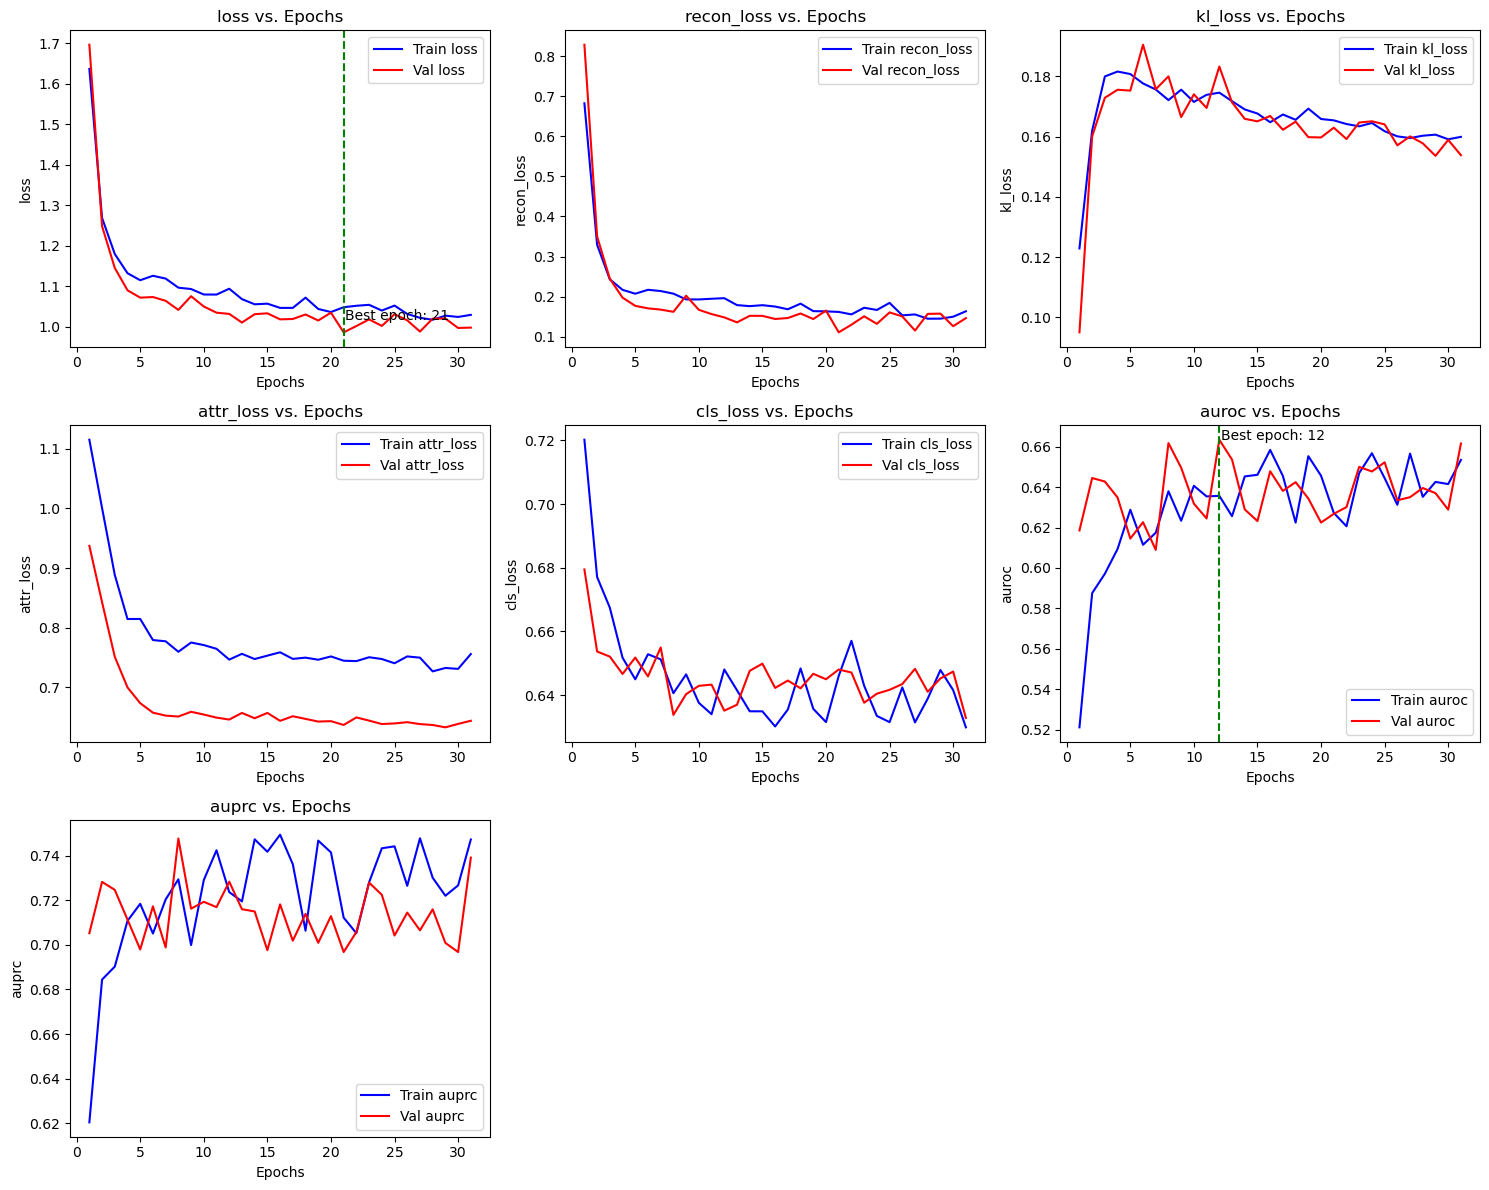

In [ ]:
# Set up TensorBoard
from torch.utils.tensorboard import SummaryWriter
import datetime

def run_experiment(config=None):
    """
    Run a complete training experiment
    
    Args:
        config: Dictionary of configuration parameters
        
    Returns:
        model: Trained model
        history: Training history
    """
    if config is None:
        config = {
            # Model parameters
            'latent_dim': 32,
            'embed_dim': 16,
            'hidden_dim': 64,
            'medical_safety': True,
            
            # Training parameters
            'batch_size': 32,
            'lr': 1e-3,
            'weight_decay': 1e-5,
            'n_epochs': 100,
            'early_stopping_patience': 10,
            
            # Loss weights
            'beta': 1.0,    # KL weight
            'gamma': 0.1,   # Attribute regularization weight
            'delta': 0.1,   # Medical safety weight
            'lambda_reg': 0.5,  # Group sparsity weight
        }
    
    # Create output directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    output_dir = f"./runs/{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save configuration
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    # Create TensorBoard writer
    writer = SummaryWriter(output_dir)
    
    # Create TensorBoard callback
    tb_callback = TensorboardCallback(writer)
    
    # Load data
    print("Loading data...")
    X_timepoints, y, attributes = load_mi_data()
    train_loader, val_loader, test_loader = create_data_loaders(
        X_timepoints, y, attributes,
        batch_size=config['batch_size']
    )
    
    # Get input dimensions and timepoint names
    input_dims = [X.shape[1] for X in X_timepoints.values()]
    timepoint_names = list(X_timepoints.keys())
    attribute_dims = {attr: i for i, attr in enumerate(attributes.columns)}
    
    print(f"Input dimensions: {input_dims}")
    print(f"Timepoint names: {timepoint_names}")
    print(f"Attribute dimensions: {attribute_dims}")
    
    # Initialize model
    print("Initializing model...")
    model = GroupInterpretableVAE(
        input_dims=input_dims,
        timepoint_names=timepoint_names,
        latent_dim=config['latent_dim'],
        embed_dim=config['embed_dim'],
        hidden_dim=config['hidden_dim'],
        attribute_dims=attribute_dims,
        medical_safety=config['medical_safety']
    )
    
    # Initialize trainer
    trainer = GroupInterpretableVAETrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        beta=config['beta'],
        gamma=config['gamma'],
        delta=config['delta'],
        lambda_reg=config['lambda_reg'],
        callbacks=[tb_callback]
    )
    
    # Train model
    print("Training model...")
    history, model = trainer.train(
        n_epochs=config['n_epochs'],
        early_stopping_patience=config['early_stopping_patience'],
        checkpoint_dir=os.path.join(output_dir, 'checkpoints')
    )
    
    # Attach trainer to model for later evaluation
    model.trainer = trainer
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dims': input_dims,
            'timepoint_names': timepoint_names,
            'latent_dim': config['latent_dim'],
            'embed_dim': config['embed_dim'],
            'hidden_dim': config['hidden_dim'],
            'attribute_dims': attribute_dims,
            'medical_safety': config['medical_safety']
        }
    }, os.path.join(output_dir, 'final_model.pt'))
    
    # Plot training history
    plot_training_history(history)
    
    # Visualize latent space
    visualize_latent_space(model, test_loader, device)
    
    # Visualize group sparsity
    visualize_group_sparsity(model)
    
    # Visualize attribute regularization
    visualize_attribute_regularization(model, test_loader, device)
    
    # Evaluate model on test data
    test_metrics = evaluate_model(model, test_loader, device)
    
    # Save test metrics
    with open(os.path.join(output_dir, 'test_metrics.json'), 'w') as f:
        # Convert values to float for JSON serialization
        test_metrics_json = {k: float(v) for k, v in test_metrics.items()}
        json.dump(test_metrics_json, f, indent=4)
    
    print(f"Experiment complete. Results saved to {output_dir}")
    print(f"View TensorBoard with: tensorboard --logdir={output_dir}")
    
    return model, history

# Run the experiment
model, history = run_experiment()